## Data importing

### Download data

In [1]:
# from https://quarry.wmflabs.org/query/17277

!wget https://quarry.wmflabs.org/run/163640/output/0/tsv?download=true -O botvbot-enwiki-comments.tsv

--2017-03-17 18:06:27--  https://quarry.wmflabs.org/run/163640/output/0/tsv?download=true
Resolving quarry.wmflabs.org (quarry.wmflabs.org)... 208.80.155.156
Connecting to quarry.wmflabs.org (quarry.wmflabs.org)|208.80.155.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘botvbot-enwiki-comments.tsv’

botvbot-enwiki-comm     [     <=>            ] 156.72M  1.34MB/s    in 2m 20s  

2017-03-17 18:08:48 (1.12 MB/s) - ‘botvbot-enwiki-comments.tsv’ saved [164330289]



In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
sns.set()

pd.options.display.max_columns = 50

### Import to pandas dataframe

In [3]:
df = pd.read_csv("botvbot-enwiki-comments.tsv", sep="\t", encoding="utf-8")

In [4]:
len(df)

480329

In [5]:
print(df.columns)

Index(['rev_id', 'rev_timestamp', 'rev_user', 'rev_user_text', 'rev_page',
       'rev_sha1', 'rev_minor_edit', 'rev_deleted', 'rev_parent_id',
       'archived', 'reverting_id', 'reverting_timestamp', 'reverting_user',
       'reverting_user_text', 'reverting_page', 'reverting_sha1',
       'reverting_minor_edit', 'reverting_deleted', 'reverting_parent_id',
       'reverting_archived', 'rev_revert_offset', 'revisions_reverted',
       'reverted_to_rev_id', 'page_namespace', 'page_title',
       'page_is_redirect', 'rev_comment'],
      dtype='object')


## Data processing
### Create field for deleted revisions

In [6]:
df['is_deleted'] = np.where(df.rev_comment.isnull(), 1, 0)
df['is_deleted'].value_counts()

0    464229
1     16100
Name: is_deleted, dtype: int64

### Create datetime index based on date of reverting edit

In [7]:
df['reverting_timestamp_dt'] = pd.to_datetime(df['reverting_timestamp'], format="%Y%m%d%H%M%S")
df = df.set_index('reverting_timestamp_dt')

### Create field for comment text with text in brackets and parentheses removed

In [8]:
# by http://stackoverflow.com/questions/14596884/remove-text-between-and-in-python

def remove_brackets(test_str):
    test_str = str(test_str)
    ret = ''
    skip1c = 0
    skip2c = 0
    for i in test_str:
        if i == '[':
            skip1c += 1
        elif i == '(':
            skip2c += 1
        elif i == ']' and skip1c > 0:
            skip1c -= 1
        elif i == ')'and skip2c > 0:
            skip2c -= 1
        elif skip1c == 0 and skip2c == 0:
            ret += i
    return ret

In [9]:
df['rev_comment_nobracket'] = df['rev_comment'].apply(remove_brackets)

### Create second dataset for ns0 / articles only

In [10]:
df_ns0 = df[df['page_namespace'] == 0].copy()

## Exploratory analysis

### Most frequent comments in ns0 reverts, with text in brackets & parens removed

In [11]:
other_count = 0
for comment, count in df_ns0['rev_comment_nobracket'].value_counts().iteritems():
    if count > 100:
        print(count, "\t", comment)
    else:
        other_count = other_count + count
print(other_count, "\tOther cases")

55130 	  Migrating 1 interwiki links, now provided by  on 
46156 	 Robot: Fixing double redirect to 
13654 	 Bot: Fixing double redirect to 
12456 	  Migrating 2 interwiki links, now provided by  on 
10061 	 Robot: Fixing double redirect
7889 	 r2.7.1) 
5260 	  Migrating 3 interwiki links, now provided by  on 
3995 	 robot Modifying: 
3770 	 Fixing identified double redirect
3545 	 nan
3297 	 r2.6.4) 
3234 	 robot Removing: 
3054 	 r2.7.2) 
2971 	 r2.7.3) 
2965 	 Bot: Migrating 1 interwiki links, now provided by  on 
2840 	 Bot: Migrating 1 langlinks, now provided by Wikidata on 
2629 	 removing a protection template from a non-protected page 
2620 	 robot  Modifying: 
1908 	  has been moved; it now redirects to .
1483 	 robot  Adding: 
1363 	 robot  Removing: 
1192 	 r2.7.2+) 
1189 	 r2.5.5) 
1026 	 robot Adding: 
822 	 r2.6.5) 
704 	 removing non-applicable orphan template
650 	  Migrating 4 interwiki links, now provided by  on  
577 	 r2.5.2) 
562 	 Robot: moving pages out of redire

## Categorizing types of bot activity based on comments

In [12]:
def comment_categorization(row):
    
    reverting_user = str(row['reverting_user_text'])
    
    if reverting_user.find("HBC AIV") >= 0:
        return 'AIV helperbot'
    
    try:
        comment = str(row['rev_comment'])
    except Exception as e:
        return 'other'
 
    if comment == 'nan':
        return "deleted revision"
        
    elif comment.find("Reverted edits by [[Special:Contributions/ImageRemovalBot") >= 0:
        return "botfight: 718bot vs ImageRemovalBot"
    
    elif comment.lower().find("double redirect") >= 0:
        return "fixing double redirect"
    
    elif comment.lower().find("double-redirect") >= 0:
        return "fixing double redirect"

    elif comment.lower().find("has been moved; it now redirects to") >= 0:
        return "fixing double redirect"
        
    elif comment.lower().find("redirect tagging") >= 0:
        return "redirect tagging/sorting"
    
    elif comment.lower().find("sorting redirect") >= 0:
        return "redirect tagging/sorting"
    
    elif comment.lower().find("change redirected category") >= 0:
        return "category redirect cleanup"
    
    elif comment.lower().find("redirected category") >=0:
        return "category redirect cleanup"
    
    elif comment.find("[[User:Addbot|Bot:]] Adding ") >= 0:
        return "template tagging"
    
    elif comment.lower().find("interwiki") >= 0:
        return "interwiki link cleanup"
    
    elif comment.lower().find("langlinks") >= 0:
        return "interwiki link cleanup"
        
    elif comment.lower().find("changing category") >= 0:
        return "moving category"
    
    elif comment.lower().find("recat per") >= 0:
        return "moving category"
    
    elif comment.lower().find("moving category") >= 0:
        return "moving category"
    
    elif comment.lower().find("re-categorisation") >= 0:
        return "moving category"
    
    elif comment.lower().find("removing a protection template") >= 0:
        return "protection template cleanup"
    
    elif comment.lower().find("removing categorization template") >= 0:
        return "template cleanup"    
    
    elif comment.lower().find("rm ibid template per") >= 0:
        return "template cleanup"      
    
    elif comment.lower().find("page is not protected") >= 0:
        return "template cleanup"          
    
    elif comment.lower().find("removing protection template") >= 0:
        return "template cleanup"      
    
    elif comment.lower().find("removing orphan t") >= 0:
        return "orphan template cleanup"
    
    elif comment.lower().find("non-applicable orphan") >= 0:
        return "orphan template cleanup"
    
    elif comment.lower().find("removed orphan t") >= 0:
        return "orphan template cleanup"    
    
    elif comment.lower().find("sandbox") >= 0:
        return "clearing sandbox"
    
    elif comment.lower().find("archiving") >= 0:
        return "archiving"
    
    elif comment.lower().find("duplicate on commons") >= 0:
        return "commons image migration"
    
    elif comment.lower().find("user:mathbot/changes to mathlists") >= 0:
        return "mathbot mathlist updates"
    
    
    #   Note: these interwiki links may be a bit broad. They have a country code following
    #   the first [[, but there are many country codes and I need a better way of searching
    #   for that.
    
    elif comment.lower().find("robot: adding [[") >= 0:
        return "interwiki link cleanup"
    
    elif comment.lower().find("robot: modifying [[") >= 0:
        return "interwiki link cleanup"
    
    elif comment.lower().find("robot: deleting [[") >= 0:
        return "interwiki link cleanup"  
    
    elif comment.lower().find("robot: removing [[") >= 0:
        return "interwiki link cleanup"      

    elif comment.lower().find("robot adding: [[") >= 0:
        return "interwiki link cleanup"
    
    elif comment.lower().find("robot modifying: [[") >= 0:
        return "interwiki link cleanup"
    
    elif comment.lower().find("robot deleting: [[") >= 0:
        return "interwiki link cleanup"  
    
    elif comment.lower().find("robot removing: [[") >= 0:
        return "interwiki link cleanup"      
    
    elif comment.lower().find("robot  adding:[[") >= 0:
        return "interwiki link cleanup"
    
    elif comment.lower().find("robot  modifying: [[") >= 0:
        return "interwiki link cleanup"
    
    elif comment.lower().find("robot  deleting: [[") >= 0:
        return "interwiki link cleanup"  
    
    elif comment.lower().find("robot  removing: [[") >= 0:
        return "interwiki link cleanup"    
    
    elif comment.lower().find("link syntax") >= 0:
        return "link syntax fixing"
    
    elif comment.lower().find("links syntax") >= 0:
        return "link syntax fixing" 
    
    elif comment.lower().find(" per") >= 0:
        return "other w/ per justification"  
    
    else:
        return "other"

### Apply categorization

In [13]:
df['bottype'] = df.apply(comment_categorization, axis=1)
df_ns0['bottype'] = df_ns0.apply(comment_categorization, axis=1)

### Set type to "other redirect" for other cases on redirect pages

In [14]:
df.loc[(df['bottype'] == 'other') & (df['page_is_redirect'] == 1), ['bottype']] = 'other redirect'
df_ns0.loc[(df_ns0['bottype'] == 'other') & (df_ns0['page_is_redirect'] == 1), ['bottype']] = 'other redirect'

# Analysis

## Types of bot-vs-bot reverts across all namespaces

### Counts

In [15]:
df['bottype'].value_counts()

interwiki link cleanup                 230475
fixing double redirect                  90013
AIV helperbot                           77390
other                                   22644
other w/ per justification              19687
deleted revision                        16046
archiving                                8268
clearing sandbox                         5080
moving category                          3302
protection template cleanup              2819
category redirect cleanup                1517
orphan template cleanup                  1028
other redirect                            997
mathbot mathlist updates                  519
botfight: 718bot vs ImageRemovalBot       173
redirect tagging/sorting                  163
link syntax fixing                        111
template cleanup                           68
template tagging                           24
commons image migration                     5
Name: bottype, dtype: int64

### Percentages

In [16]:
df['bottype'].value_counts(normalize=True) * 100

interwiki link cleanup                 47.982737
fixing double redirect                 18.739864
AIV helperbot                          16.111873
other                                   4.714269
other w/ per justification              4.098649
deleted revision                        3.340627
archiving                               1.721320
clearing sandbox                        1.057608
moving category                         0.687445
protection template cleanup             0.586889
category redirect cleanup               0.315825
orphan template cleanup                 0.214020
other redirect                          0.207566
mathbot mathlist updates                0.108051
botfight: 718bot vs ImageRemovalBot     0.036017
redirect tagging/sorting                0.033935
link syntax fixing                      0.023109
template cleanup                        0.014157
template tagging                        0.004997
commons image migration                 0.001041
Name: bottype, dtype

### Plot

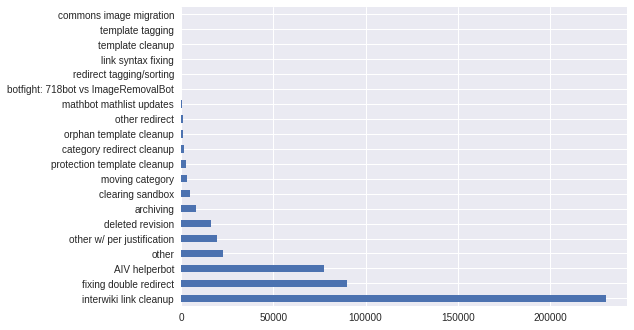

In [17]:
df['bottype'].value_counts().plot(kind='barh')

## Types of bot-vs-bot reverts in ns0 / articles

### Counts

In [18]:
df_ns0['bottype'].value_counts()

interwiki link cleanup                 116906
fixing double redirect                  81907
other                                    3709
deleted revision                         3545
protection template cleanup              2631
moving category                          1987
orphan template cleanup                  1020
category redirect cleanup                 977
other redirect                            590
mathbot mathlist updates                  515
other w/ per justification                426
botfight: 718bot vs ImageRemovalBot       170
redirect tagging/sorting                  163
link syntax fixing                         85
template cleanup                           68
template tagging                           24
commons image migration                     3
clearing sandbox                            1
Name: bottype, dtype: int64

### Percentages

In [19]:
df_ns0['bottype'].value_counts(normalize=True)* 100

interwiki link cleanup                 54.444015
fixing double redirect                 38.144714
other                                   1.727310
deleted revision                        1.650934
protection template cleanup             1.225277
moving category                         0.925361
orphan template cleanup                 0.475022
category redirect cleanup               0.454996
other redirect                          0.274767
mathbot mathlist updates                0.239839
other w/ per justification              0.198391
botfight: 718bot vs ImageRemovalBot     0.079170
redirect tagging/sorting                0.075910
link syntax fixing                      0.039585
template cleanup                        0.031668
template tagging                        0.011177
commons image migration                 0.001397
clearing sandbox                        0.000466
Name: bottype, dtype: float64

### Plot

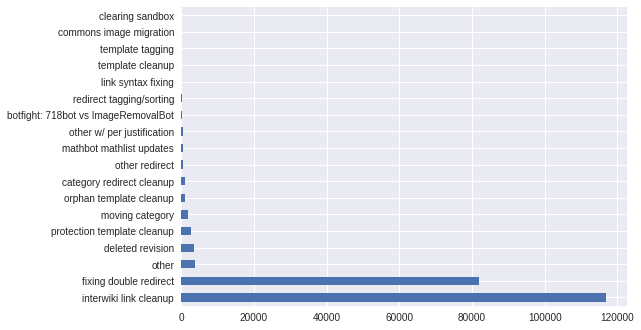

In [20]:
df_ns0['bottype'].value_counts().plot(kind='barh')

## Timeseries visualizations

### All namespaces plot of bot-vs-bot reverts over time, grouped weekly

In [21]:
gb_all = df.groupby([pd.TimeGrouper('1W', closed='left')])

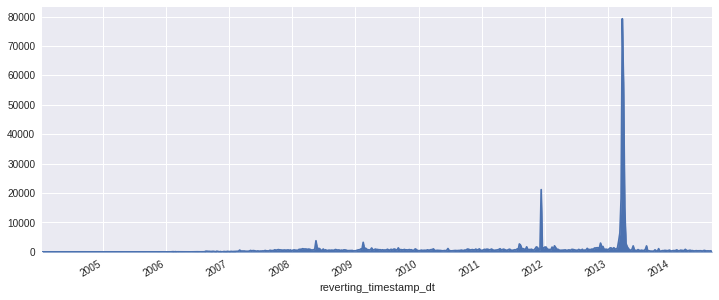

In [22]:
ax1 = gb_all.rev_id.count().plot(kind='area', figsize=[12,5])

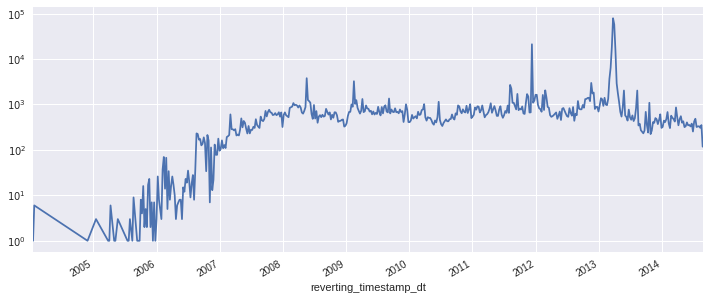

In [23]:
ax1 = gb_all.rev_id.count().plot(kind='line', figsize=[12,5], logy=True)

### Article / ns0 plot of bot-vs-bot reverts over time, grouped weekly

In [24]:
gb_ns0 = df_ns0.groupby([pd.TimeGrouper('1W', closed='left')])

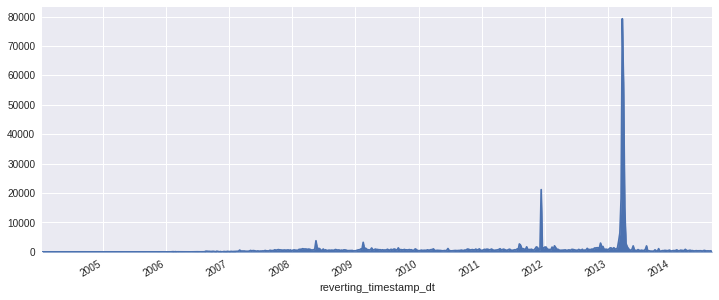

In [25]:
ax1 = gb_all.rev_id.count().plot(kind='area', figsize=[12,5])

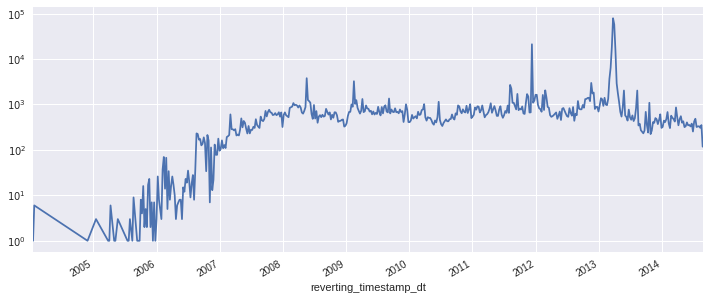

In [26]:
ax1 = gb_all.rev_id.count().plot(kind='line', figsize=[12,5], logy=True)

### Group by daily counts for each bot type, all namespaces

In [27]:
gp = df.groupby([pd.TimeGrouper('1D', closed='left'), 'bottype'])

### Subplots by bot type, no shared y axis

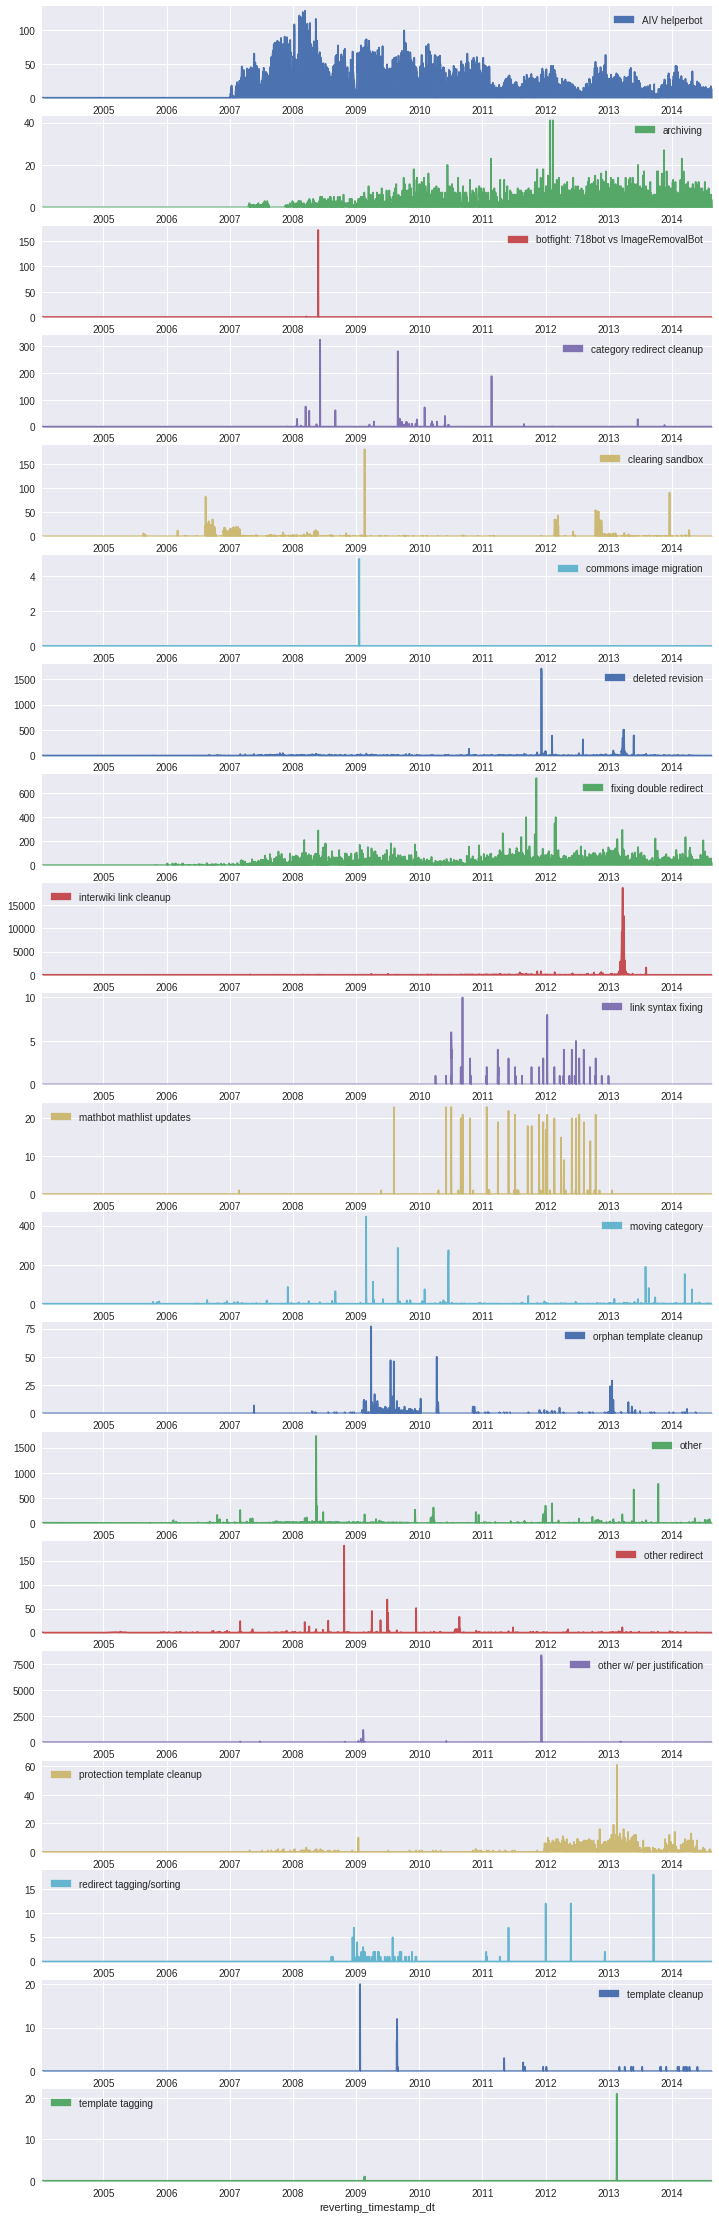

In [28]:
ax1 = gp.rev_id.count().unstack().plot(kind='area', subplots=True, figsize=[12,40], sharex=False)

### Subplots by bot type, shared y axis

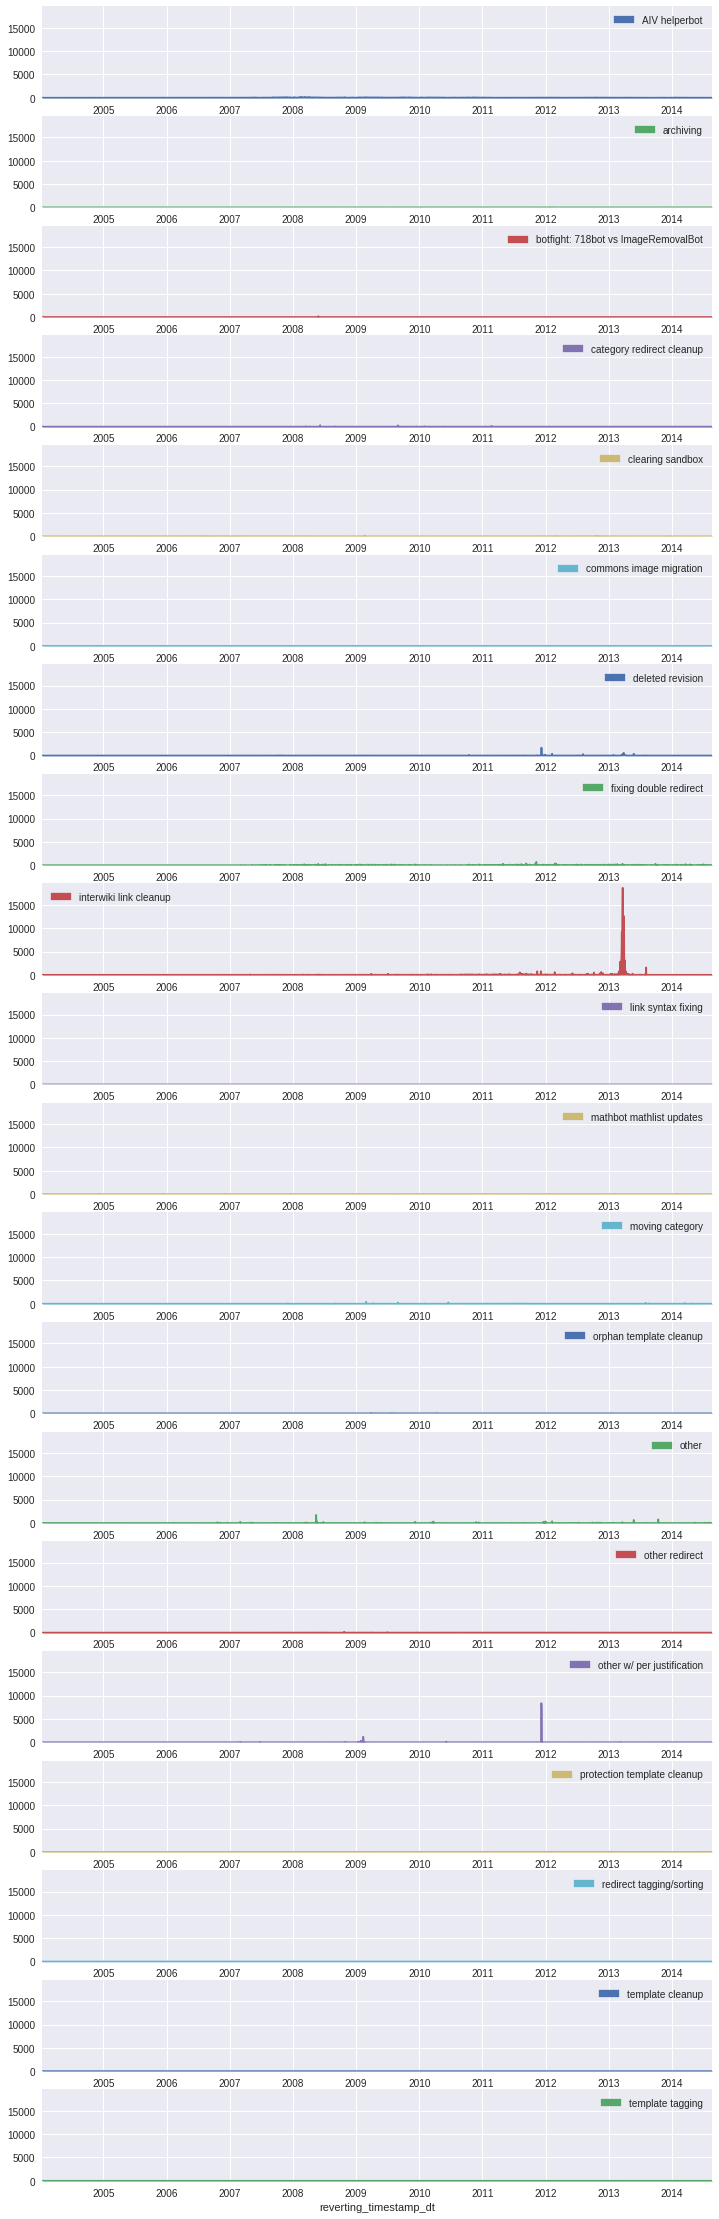

In [29]:
ax2 = gp.rev_id.count().unstack().plot(kind='area', subplots=True, figsize=[12,40], sharex=False, sharey=True)

### Group by daily counts for each bot type, ns0 / articles only

In [30]:
gp_ns0 = df_ns0.groupby([pd.TimeGrouper('1D', closed='left'), 'bottype'])

### Subplots by bot type, no shared y axis

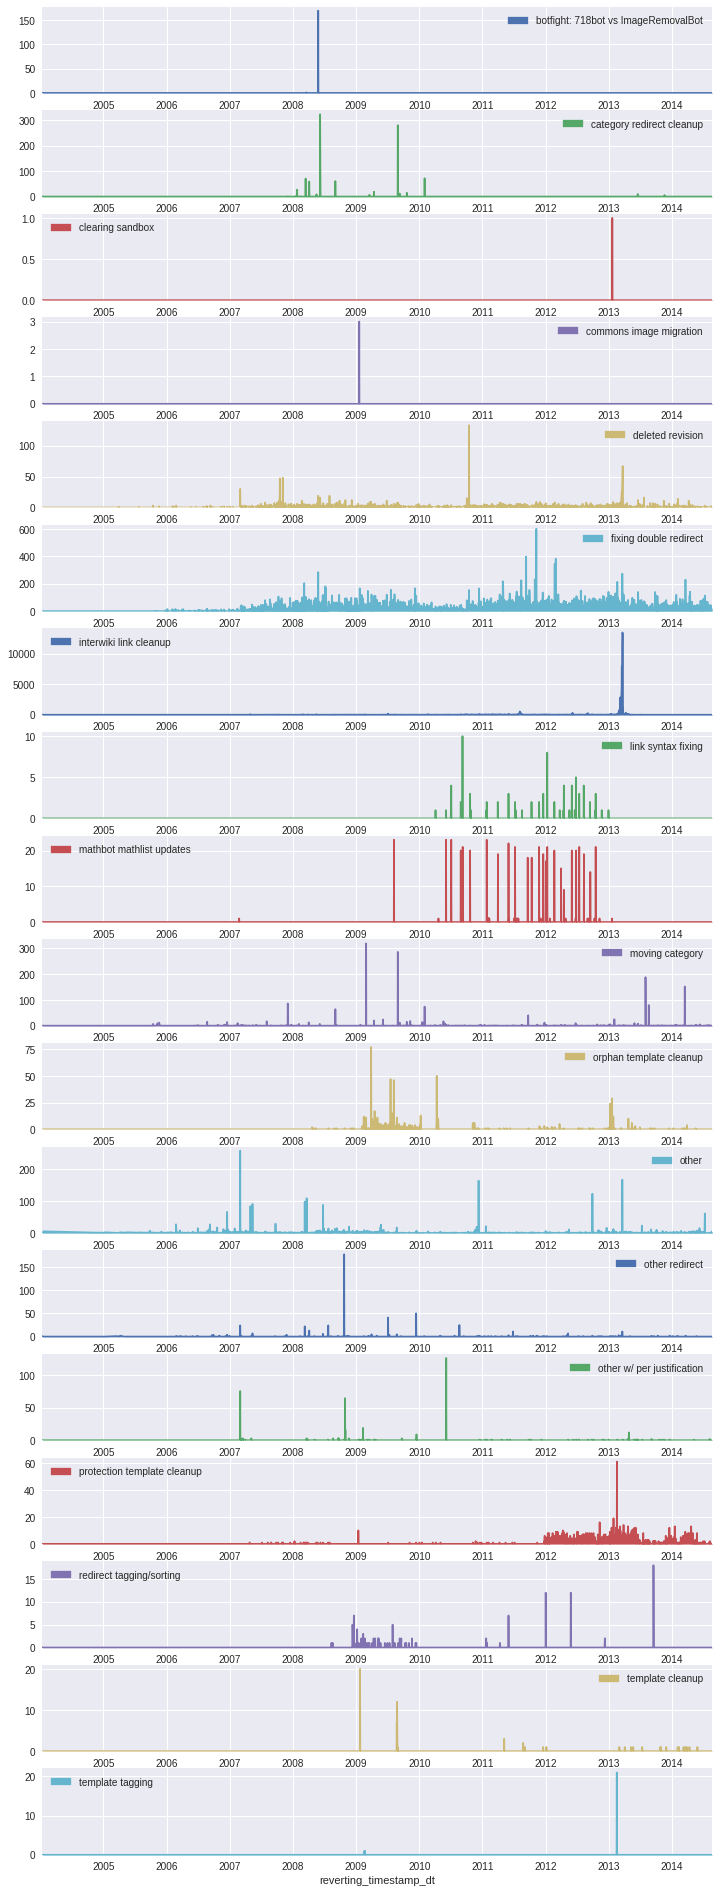

In [31]:
ax3 = gp_ns0.rev_id.count().unstack().plot(kind='area', subplots=True, figsize=[12,34], sharex=False)

### Subplots by bot type, shared y axis

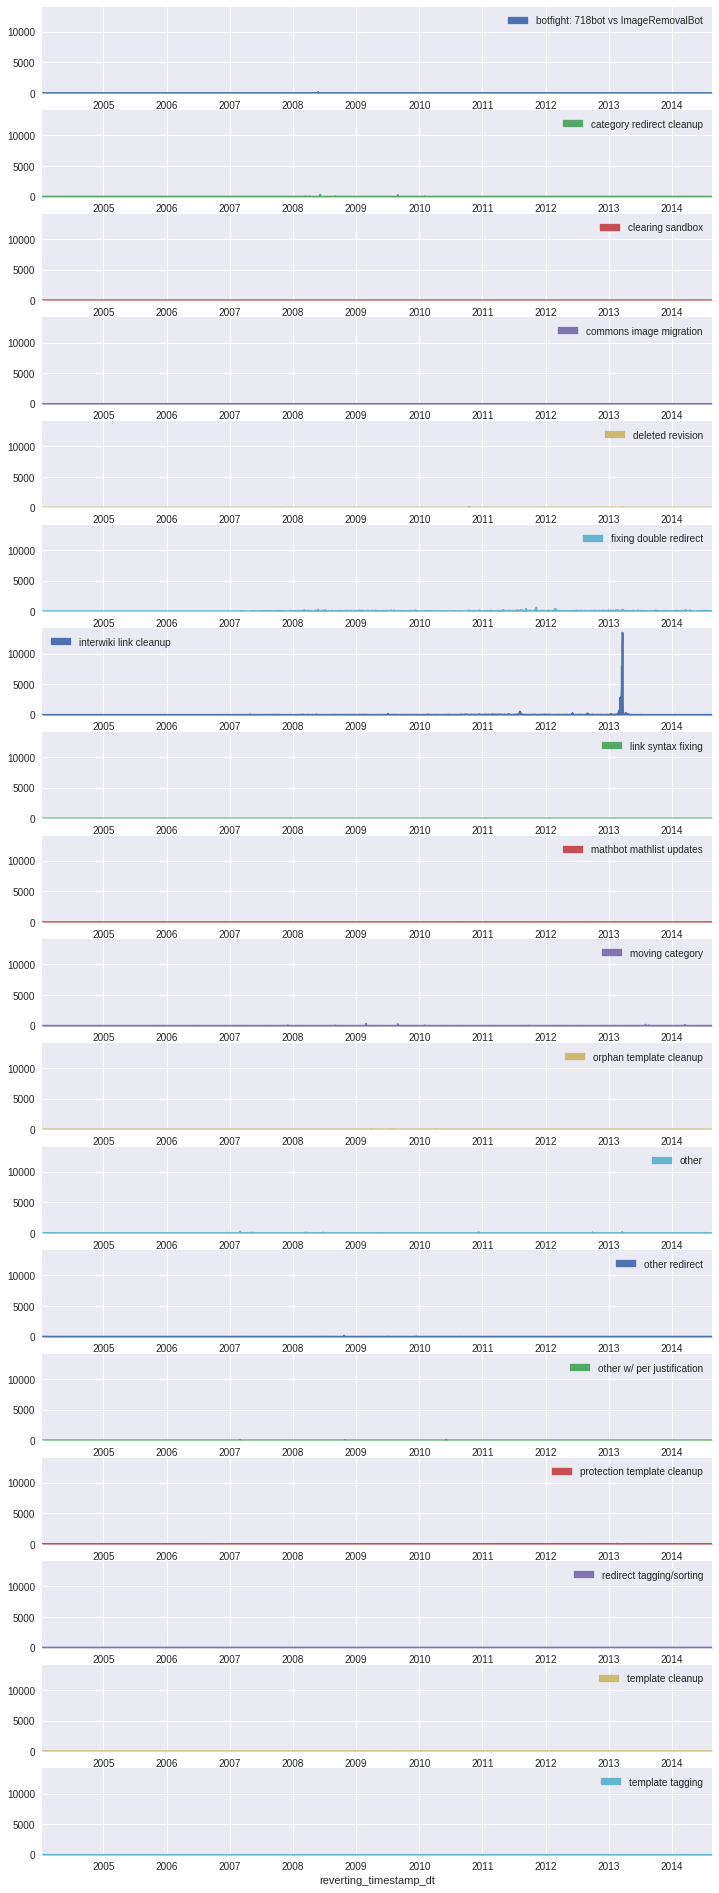

In [32]:
ax4 = gp_ns0.rev_id.count().unstack().plot(kind='area', subplots=True, figsize=[12,34], sharex=False, sharey=True)

## What wasn't categorized in ns0?

In [33]:
other_count = 0
for comment, count in df_ns0[df_ns0['bottype']=='other']['rev_comment'].value_counts().iteritems():
    if count > 10:
        print(count, "\t", comment)
    else:
        other_count = other_count + count
print(other_count, "\tOther cases")

253 	 Correcting template, Replaced: {{4CC → {{disambig  using [[Project:AWB|AWB]]
215 	 Reverting incorrect removal by CommonsDelinker (file still exists on local wiki)
149 	 removing incominglinks template; fewer than 25 links
89 	 Undoing massive unnecessary addition of infoboxneeded by a (now blocked) bot.
66 	 Add category Rockaway, Queens that was inadvertently deleted  using [[Project:AWB|AWB]]
36 	 [[WP:CHECKWIKI]] error fixes using [[Project:AWB|AWB]] (10300)
27 	 BOT - automated removal of category [[Category:Filipino singers|Filipino singers]]
27 	 Robot: Changing template: corp-stub
24 	 /* References */[[WP:CHECKWIKI]] error fixes using [[Project:AWB|AWB]] (10300)
21 	 Fixed/removed {{expand}} + [[WP:CHECKWIKI]] error fixes + [[WP:GENFIXES|general fixes]], removed expand tag using [[Project:AWB|AWB]] (7552)
17 	 Daily update. See [[User:Mathbot/Changes mathlist]] for changes.
14 	 /* External links */[[WP:CHECKWIKI]] error fixes using [[Project:AWB|AWB]] (9345)
13 	 Bot: c

In [34]:
other_count = 0
for comment, count in df_ns0[df_ns0['bottype']=='other']['rev_comment_nobracket'].value_counts().iteritems():
    if count > 10:
        print(count, "\t", comment)
    else:
        other_count = other_count + count
print(other_count, "\tOther cases")

1439 	 robot  Adding: 
253 	 Correcting template, Replaced: {{4CC → {{disambig  using 
215 	 Reverting incorrect removal by CommonsDelinker 
149 	 removing incominglinks template; fewer than 25 links
145 	 Перемещение 1 интервики-ссылки в Викиданные 
89 	 Undoing massive unnecessary addition of infoboxneeded by a  bot.
66 	 Add category Rockaway, Queens that was inadvertently deleted  using 
50 	 Robot removes iw-link to deleted page 
50 	  error fixes using  
38 	 robot  Adding: , 
36 	 /* References */ error fixes using  
27 	 Robot: Changing template: corp-stub
27 	 BOT - automated removal of category 
23 	 /* External links */ error fixes using  
21 	 Перемещение 2 интервики-ссылок в Викиданные 
21 	 Fixed/removed {{expand}} +  error fixes + , removed expand tag using  
17 	 Daily update. See  for changes.
17 	 /* External links */ error fixes +  using  
15 	 Updating {{}}. 
14 	 r2.7.1) 
14 	 r2.7.2) 
13 	 Bot: category redirect - changing  to 
13 	 Removing links to deleted file 

In [35]:
other_count = 0
for comment, count in df[df['bottype']=='other']['reverting_user_text'].value_counts().iteritems():
    if count > 25:
        print(count, "\t", comment)
    else:
        other_count = other_count + count
print(other_count, "\tOther cases")

3289 	 ClueBot II
2660 	 BetacommandBot
1966 	 Fbot
1838 	 AvicBot2
923 	 ContinuityBot
854 	 Yobot
835 	 Xenobot
779 	 Amalthea (bot)
731 	 WildBot
663 	 Svenbot
464 	 Shadowbot3
441 	 AnomieBOT
426 	 JAnDbot
316 	 John Bot
308 	 Commons fair use upload bot
270 	 Ganeshbot
253 	 STBot
207 	 Addbot
200 	 AlnoktaBOT
179 	 Innocent iwbot
177 	 Yetanotherbot
174 	 EmausBot
164 	 VWBot
153 	 DPL bot
145 	 Werdnabot
138 	 SoxBot V
129 	 ListasBot
128 	 Chris G Bot 3
122 	 LivingBot
119 	 EdwardsBot
103 	 SoxBot II
102 	 Chlewbot
100 	 Thijs!bot
89 	 Roomba
89 	 TXiKiBoT
87 	 SieBot
82 	 Roboto de Ajvol
80 	 VolkovBot
78 	 DHN-bot
74 	 LostBot
73 	 VoABot II
70 	 SmackBot
67 	 DomBot
61 	 Femto Bot
58 	 AntiVandalBot
55 	 YurikBot
53 	 Escarbot
51 	 OverlordQBot
46 	 ShepBot
45 	 Chobot
43 	 Cydebot
42 	 BotMultichill
41 	 Zorrobot
34 	 Hazard-Bot
33 	 SpBot
33 	 BenzolBot
32 	 Ficbot
31 	 FrescoBot
30 	 Numbo3-bot
30 	 BG19bot
30 	 CarsracBot
29 	 Mathbot
28 	 Alexbot
28 	 TPO-bot
28 	 BOT-

In [36]:
pd.options.display.max_rows = 1000
df_ns0[df_ns0['bottype'] == 'other'][['reverting_user_text', 'rev_user_text', 'rev_comment', 'page_is_redirect']]

,reverting_user_text,rev_user_text,rev_comment,page_is_redirect
reverting_timestamp_dt,,,,
2005-07-20 16:29:05,HasharBot,Robbot,"robot Adding: ca, fr",0.0
2004-11-24 02:51:15,Jumbuck,Robbot,robot Modifying:fr,0.0
2005-07-15 07:01:19,YurikBot,Robbot,robot Adding: ru,0.0
2005-08-16 01:51:28,Zwobot,Robbot,robot Adding: eo,0.0
2008-08-28 21:58:57,Thijs!bot,Robbot,robot Adding: [[es:Madonne-et-Lamerey]],0.0
2008-10-05 03:17:11,Escarbot,Robbot,robot Adding: [[es:Mareil-le-Guyon]],0.0
2007-04-01 14:10:57,Botx,Robbot,robot Adding: [[es:Abejorro]],0.0
2007-02-19 21:56:11,TXiKiBoT,Robbot,robot Adding: [[pam:Barangay]],0.0
2008-10-05 15:33:16,TXiKiBoT,Robbot,robot Adding: [[es:Mareil-sur-Mauldre]],0.0


# Export

In [37]:
df.to_pickle("botvbot-enwiki-comments-allns-processed.pickle")
df.to_csv("botvbot-enwiki-comments-allns-processed.tsv", sep="\t")
df_ns0.to_pickle("botvbot-enwiki-comments-ns0-processed.pickle")
df_ns0.to_csv("botvbot-enwiki-comments-ns0-processed.tsv", sep="\t")